In [142]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-034b792a-fa9b-ad70-394b-cef0b8f024b1)


In [2]:
import os
from pathlib import Path
from glob import glob
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
from tqdm.auto import tqdm
import copy
import time
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
# from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp

In [9]:
dir_struct = """
FloodNet Challenge @ EARTHVISION 2021 - Track 1
Flood Detection
|
└──>data
    |
    │──>ColorPalette-Values.xlsx
    │
    └──>train
    │   │
    │   └──>images
    │   │
    │   └──>labels
    │   │
    │   └──>enc_labels
    │
    |──>test
    |    │
    |    └──>images
    │    │
    │    └──>labels
    │    │
    │    └──>enc_labels
    |
    |──>validation
    |    │
    |    └──>images
    │    │
    │    └──>labels
    │    │
    │    └──>enc_labels
"""

In [ ]:
CLASSES={'Background':0,'Building-flooded':1,'Building-non-flooded':2,'Road-flooded':3,'Road-non-flooded':4,
         'Water':5,'Tree':6,'Vehicle':7,'Pool':8,'Grass':9}

In [11]:
paths = sorted(glob(os.path.join("data/train/images", "*.jpg")))

In [41]:
imgs = sorted(int(x[:-8]) for x in os.listdir("data/train/labels"))

In [42]:
imgs

[6279,
 6287,
 6332,
 6334,
 6335,
 6338,
 6340,
 6341,
 6344,
 6346,
 6347,
 6348,
 6350,
 6351,
 6352,
 6354,
 6358,
 6359,
 6360,
 6361,
 6363,
 6364,
 6365,
 6367,
 6368,
 6369,
 6370,
 6372,
 6373,
 6374,
 6375,
 6376,
 6379,
 6381,
 6384,
 6385,
 6386,
 6387,
 6388,
 6393,
 6395,
 6397,
 6398,
 6399,
 6402,
 6403,
 6404,
 6407,
 6408,
 6409,
 6411,
 6413,
 6414,
 6415,
 6416,
 6421,
 6422,
 6424,
 6426,
 6427,
 6430,
 6431,
 6433,
 6435,
 6437,
 6438,
 6442,
 6443,
 6444,
 6446,
 6447,
 6450,
 6451,
 6453,
 6454,
 6455,
 6456,
 6457,
 6458,
 6459,
 6460,
 6461,
 6462,
 6463,
 6464,
 6465,
 6466,
 6469,
 6477,
 6478,
 6481,
 6484,
 6486,
 6492,
 6496,
 6498,
 6499,
 6501,
 6504,
 6505,
 6506,
 6509,
 6510,
 6512,
 6513,
 6516,
 6520,
 6523,
 6525,
 6526,
 6527,
 6528,
 6530,
 6531,
 6533,
 6534,
 6535,
 6537,
 6538,
 6540,
 6541,
 6542,
 6543,
 6544,
 6546,
 6548,
 6549,
 6552,
 6555,
 6556,
 6559,
 6560,
 6563,
 6564,
 6565,
 6566,
 6569,
 6573,
 6574,
 6580,
 6584,
 6585,
 6586,

In [100]:
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, image_transformer=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transformer = image_transformer
        img_indices = sorted(int(x[:-4]) for x in os.listdir(img_dir))
        mask_indices =  sorted(int(x[:-8]) for x in os.listdir(mask_dir))
        self.indices = [x for x in img_indices if x in mask_indices]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{self.indices[idx]}.jpg")
        mask_path = os.path.join(self.mask_dir, f"{self.indices[idx]}_lab.png")
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if self.transformer:
            return self.transformer.transform(image, mask)
        return image, mask

In [101]:
ds = SegDataset("data/train/images", "data/train/enc_labels")

In [102]:
img, mask = ds[0]

In [103]:
img.shape, mask.shape

((3000, 4000, 3), (3000, 4000))

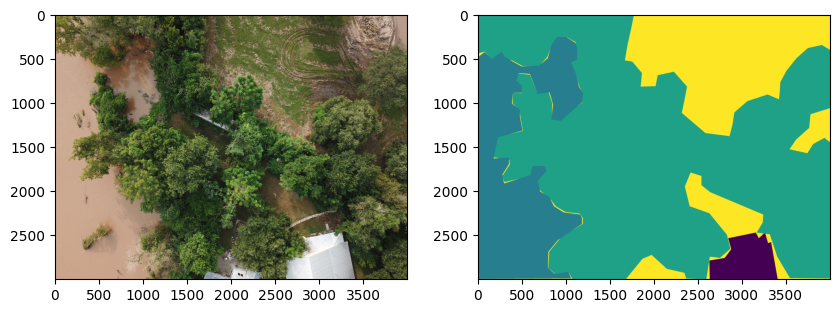

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(mask)
plt.show()

In [105]:
np.unique(np.array(mask),return_counts=True)

(array([2, 5, 6, 9], dtype=uint8),
 array([ 297765, 1903647, 7264970, 2533618], dtype=int64))

In [140]:
del ds

In [143]:
gc.collect()

28500

In [133]:
class SegImageTransformer:
    def __init__(self, split = "train", image_dims = (512, 512), num_classes = 10):
        self.transformations = A.Compose([
            A.Resize(*image_dims),
            A.Affine(scale=(0.8, 1.2), translate_percent=(0.2, 0.2),rotate=(-30, 30),  p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ]) if split == "train" else\
            A.Compose([A.Resize(*image_dims), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
        self.num_classes = num_classes
        self.to_tensor = T.ToTensor()

    @staticmethod
    def image_preprocess(image):
        kernel = np.ones((2,2),np.uint8)
        image = cv2.bilateralFilter(image, 5, 75, 75)
        image = cv2.erode(cv2.dilate(image, kernel, iterations=2), kernel, iterations=1)
        return image

    @staticmethod
    def mask_preprocess(mask, num_classes):
        mask = torch.as_tensor(mask, dtype=torch.int64)
        return torch.moveaxis(F.one_hot(mask, num_classes=num_classes), -1, 0)

    def transform(self, image, mask):
        image = self.image_preprocess(image)
        transformed = self.transformations(image=image, mask=mask)
        mask = self.mask_preprocess(transformed['mask'], num_classes=self.num_classes)
        return self.to_tensor(transformed['image']), mask

In [139]:
train_ds = SegDataset("data/train/images", "data/train/enc_labels", image_transformer=SegImageTransformer(split="train"))
val_ds = SegDataset("data/val/images", "data/val/enc_labels", image_transformer=SegImageTransformer(split="val"))

In [152]:
def dice_loss(pred, target, smooth = 1e-5):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()